## $\hspace{9cm}$ $\textbf{PROJET DATACAMP TENNIS}$

<font color='cyan'>$\textbf{CONTEXTUALIZATION}$</font>

You are a tennis coach, and your player will play against Novak Djokovic in the first round of the coming Australian Open.

To help your player prepare this match, you want to analyse Djokovic's game: during the practice sessions, you want to reproduce specific situations that could occur during the match. Ideally, you would like to be able to predict Novak's decisions at any time, based on the score of the game for instance, his position and the position of his opponent on the court, the type of surface, the characteristics of the balls etc

<font color='cyan'>$\textbf{DATA SCIENCE PROBLEM}$</font>

Such a problem may be traduced into a Machine Learning one. Let's assume some hypothesis/simplifications, among them:

- a decision = targeting a given localization (the effect applied to the ball is not considered)

- We only base the prediction of Djokovic next shot's decision at time $(T+1)$ on the information collected since the beginning of the point being played (from $t=1$ to $t=T$).

- His shots are not random but wisely chosen, which is actually the case for any professional tennis player. 

Hence, this problem turns out to be a <font color='red'>$\textbf{multi-regression task}$</font>, where:

- The input of the model, $x \in \mathcal{X}$, is a sequence $(x_0,...x_t,...,x_T)$, $x_t$ being a vector describing the situation during the t$^{th}$ shot.

- The output $y \in \mathcal{Y}$ is the coordinates $(p_x,p_y)$ that Djokovic would target for the $(T+1)^{th}$ shot of the current point.

Obviously, we implictly assert that $(i)$ at time $(T+1)$, it is Djokovic's turn to play, and $(ii)$, the previous shot correctly landed on the other court side.

There may be some cases where Djokovic wouldn't be able to reach the ball, would make a fault, or worse, maybe his shot would not even manage to go throught the net. In all these cases, it means that he would lose the point !
To encode this, we might think of a special output (that cannot lead to confusion), such as $y=(-100,-100)$.

<font color='cyan'>$\textbf{EXAMPLE:}$</font>

The image below illustrates the beginning of a point (ie sequence at $t=1$).








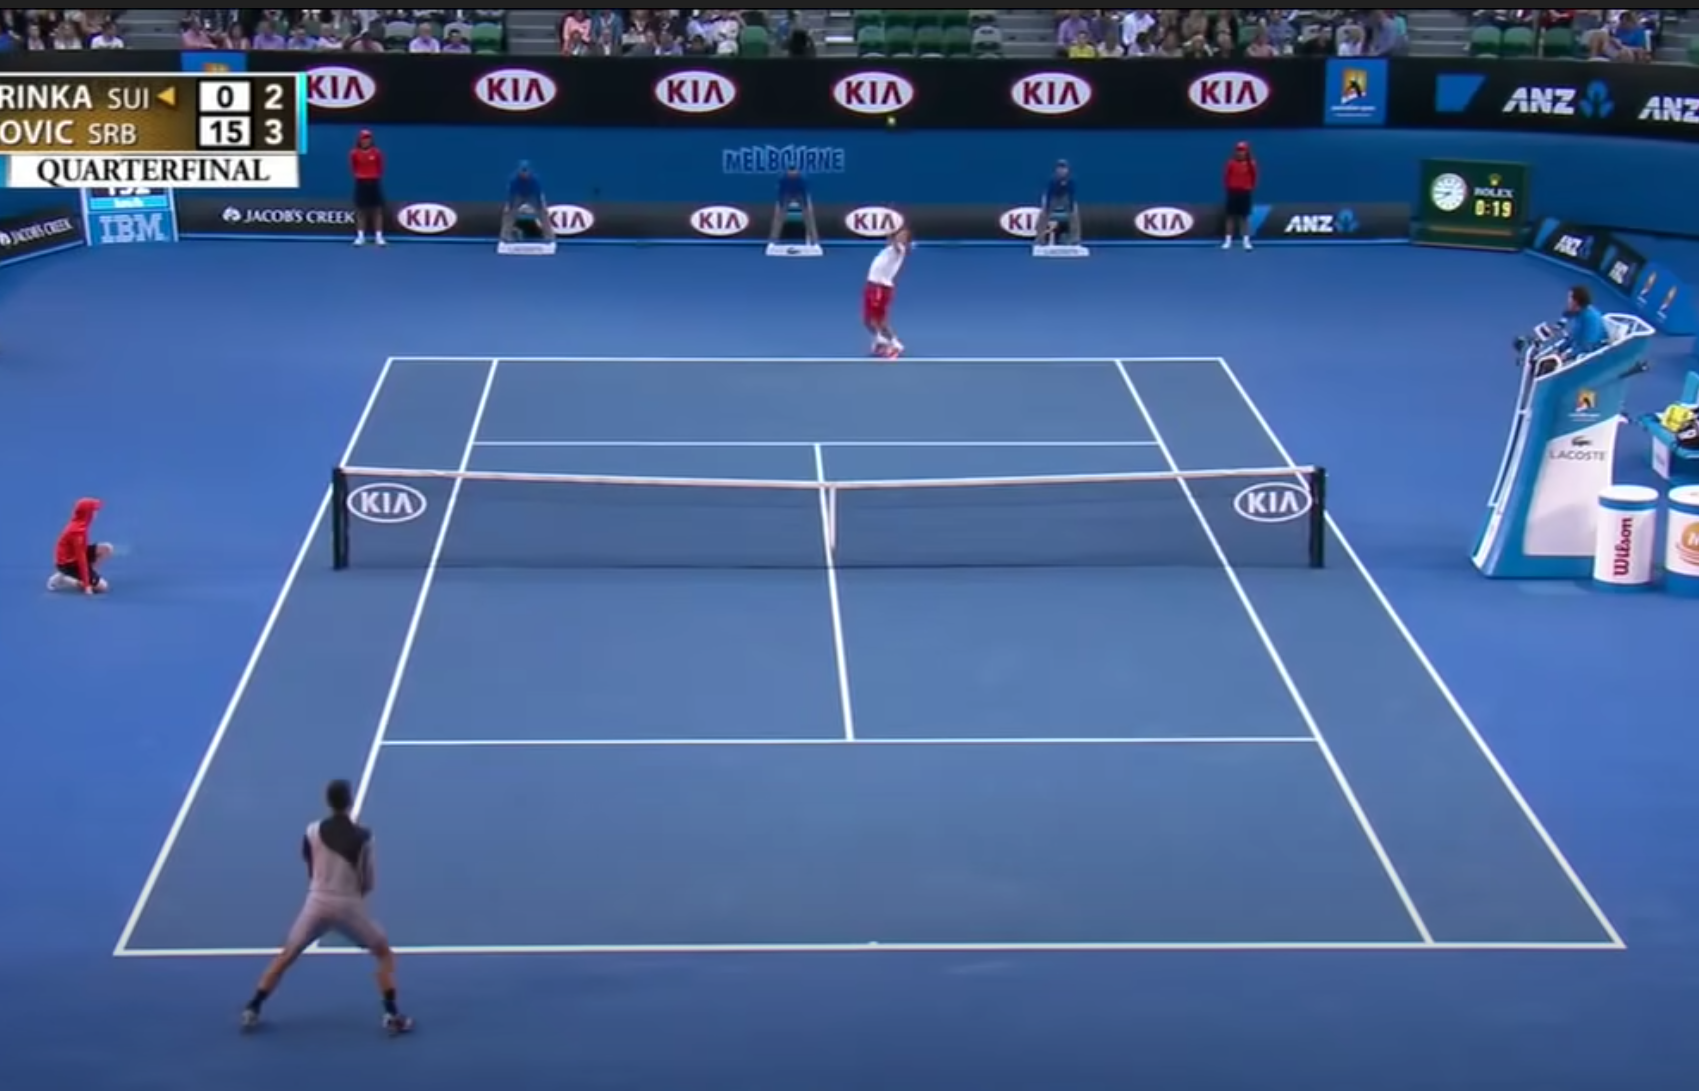

The first element $x_{t=1}$ of the sequence may contain the following descriptions:

- set_djoko = 0, set_opponent = 0 (no won has won a set yet)
- games_djoko = 3, games_opponent = 2
- serve_djoko = 0 (he returns)
- position_djoko = (-3.95, 12.6), position_opponent = (-0.64, 12.27)
- play_djoko = 0 (it is his opponent who hits the ball at $t=1$)
- ball_target = (-0.7, 6.2) which is where the ball lands due the the first shot (we need to forward the video a bit):



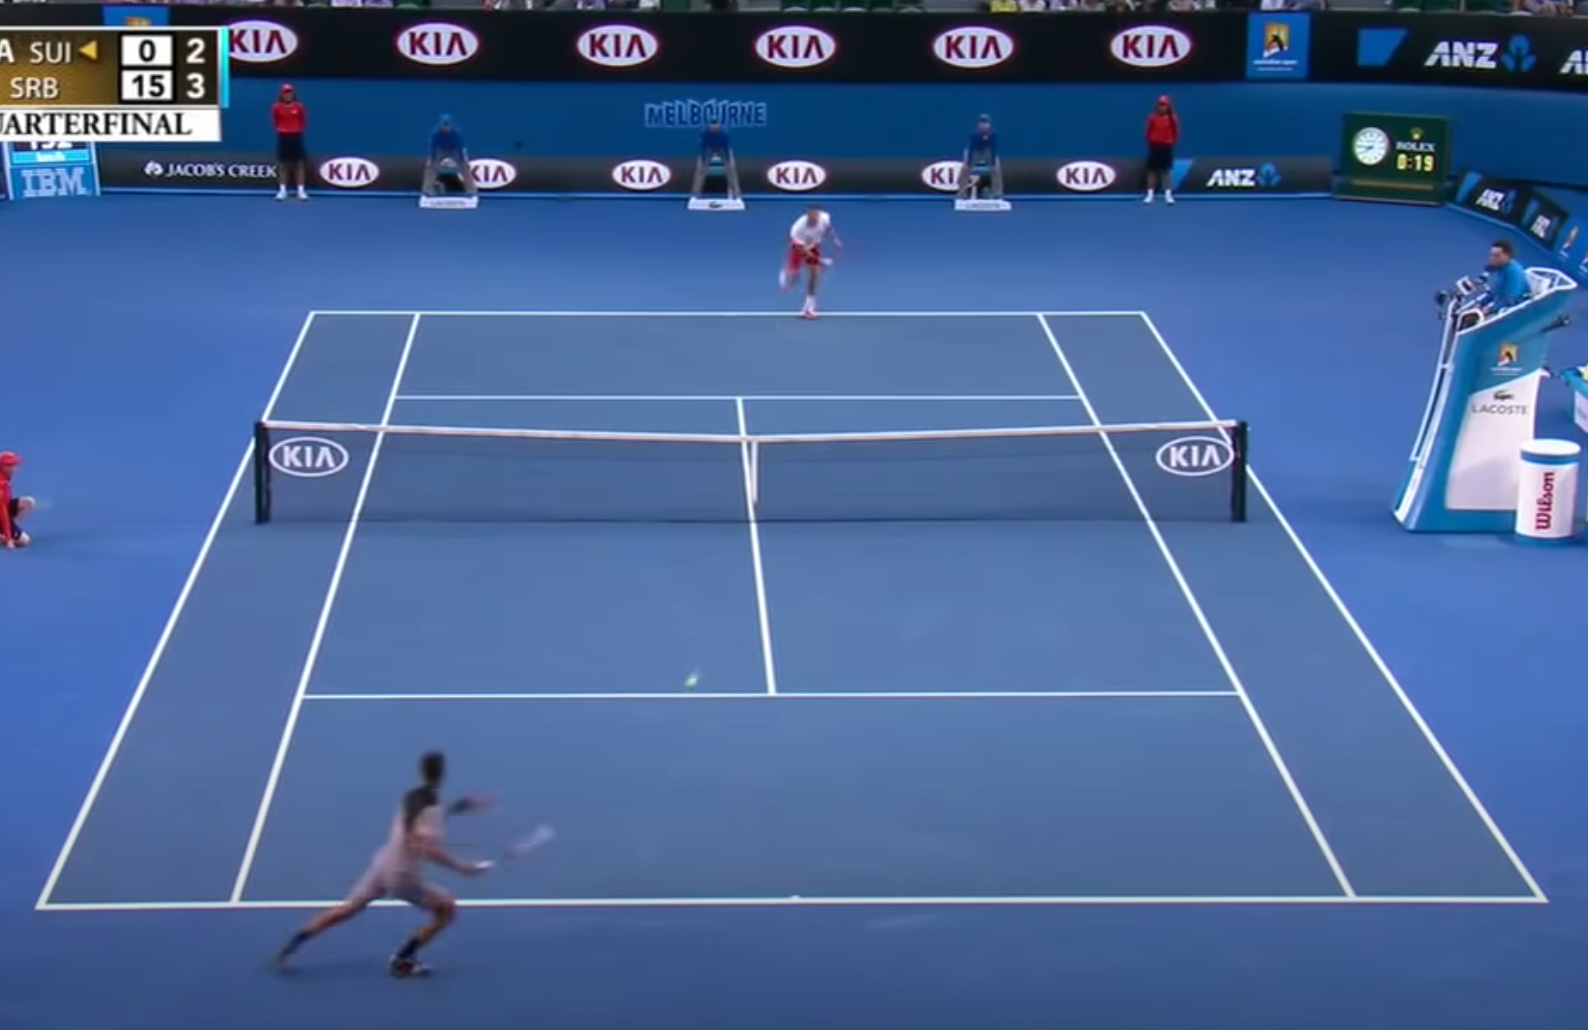

$\underline{Remarks:}$ 

- Some information, mainly related to the score of the match, are repeated along a sequence, which is not optimal. One should think of a more clever way to include these information in the dataset...

- Many features are categorical, since the number of sets is between $0$ and $3$, the number of games won (during the current set) is between $0$ and $6$...

The positions of the players are found using the below tool (does not seem to work on colab, open it via Visual Studio Code). Pointing the cursor to a given point of the tennis court should display the corresponding position, which would be very useful if we were to create the dataset.

In [13]:
#@title plot court
import matplotlib.pyplot as plt

def plot_court():
    fig = plt.figure(figsize=(8, 16))

    # ------ OVER ------
    plt.subplot(2,1,1) 
    plt.ylim(0, 14)
    plt.xlim(-6, 6)
    plt.gca().invert_xaxis()

    # horizontal lines
    plt.hlines(6.4, -4.11, 4.11)
    plt.hlines(11.9, -5.5, 5.5)

    # vertical lines
    plt.vlines(4.11, 0, 11.9)
    plt.vlines(-4.11, 0, 11.9)
    plt.vlines(0, 0, 6.4)
    plt.vlines(5.5, 0, 11.9)
    plt.vlines(-5.5, 0, 11.9)

    # ------ UNDER ------
    plt.subplot(2,1,2)  
    plt.ylim(0, 14)
    plt.gca().invert_yaxis()
    plt.xlim(-6, 6)

    # horizontal lines
    plt.hlines(6.4, -4.11, 4.11)
    plt.hlines(11.9, -5.5, 5.5)

    # vertical lines
    plt.vlines(4.11, 0, 11.9)
    plt.vlines(-4.11, 0, 11.9)
    plt.vlines(0, 0, 6.4)
    plt.vlines(5.5, 0, 11.9)
    plt.vlines(-5.5, 0, 11.9)

    # plot a few coordinates

    x = [0, 0, 0, 4.11, -4.11]
    y = [0, 11.9, 6.4, 6.4, 11.9]

    for i_x, i_y in zip(x, y):
        plt.text(i_x, i_y, '({}, {})'.format(i_x, i_y), color="red")

    plt.show()

# to get coordinates with the cursor
def mouse_move(event):
    x, y = event.xdata, event.ydata
    print(x, y)

<Figure size 432x288 with 0 Axes>

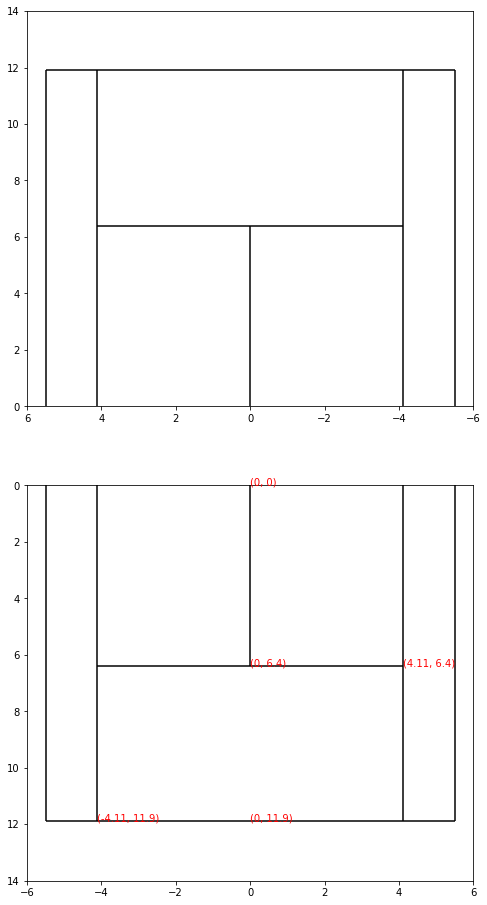

In [14]:
plt.connect('motion_notify_event', mouse_move)
plot_court()

By convention, the position is described by $(p_x, p_y)$ with $p_x$ the horizontal component and $p_y$ the vertical component.

Consider the lower part of the tennis court.
- The origin point $(0,0)$ is in the middle of the net.
- The $y$ axis points to the south, so that the closer the player is to the net (small distance from the net), the smaller is $p_y$. Conversely, the farther he is from the net (typically when he is defending), the larger $p_y$ is.
- The $x$ axis direction is as usual, ie $p_x$ is positive when we goes to the right, and negative in the opposite direction.

As a tennis court is symmetrical, if we want the position of the other player, we just rotate the upper part of the court as to superpose it with the lower part, which allows to be in the other player's perpective.

The coordinates have not been taken randomly; they follows the real dimensions of a tennis court (see https://wearetennis.bnpparibas/fr/actualites-tennis/histoire/3692-quelles-sont-les-dimensions-dun-court-de-tennis-le-point-technique-tennis-du-mois):



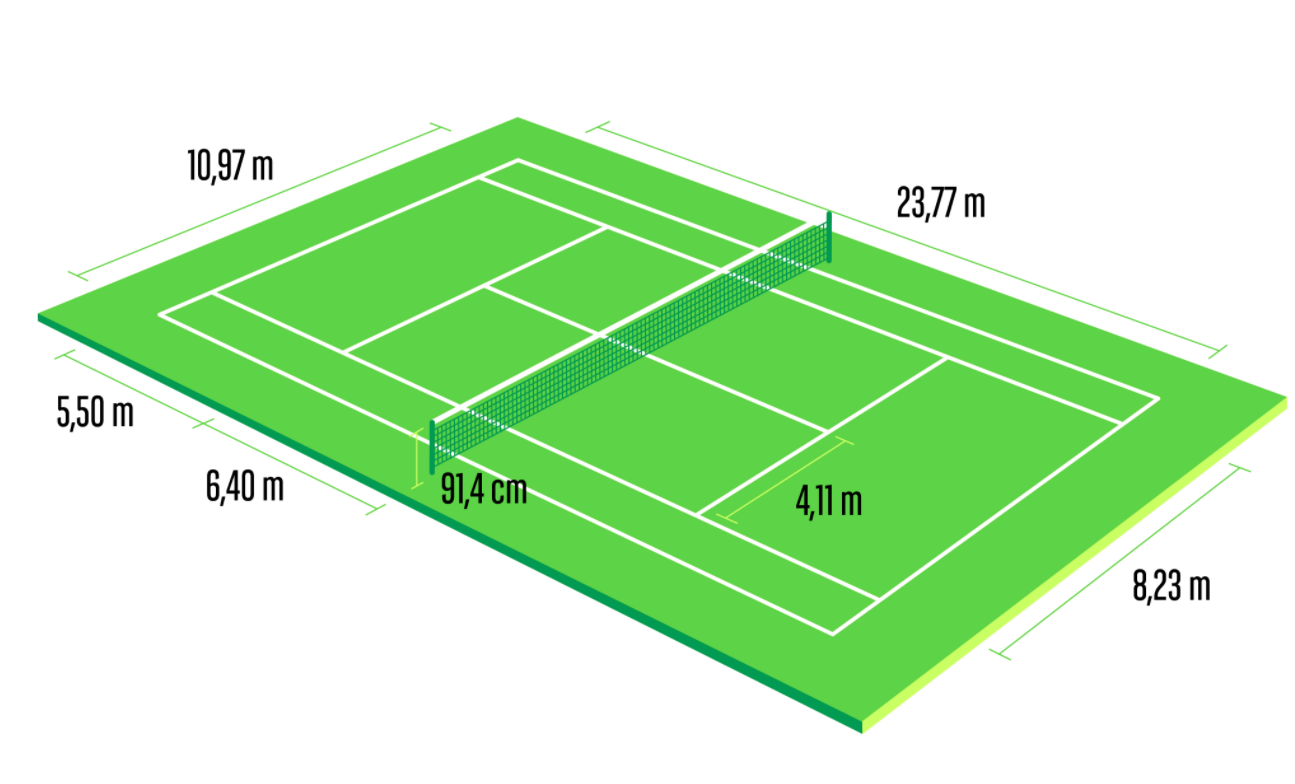

Finally, suppose we want to predict the second shot, ie where Djokovic is going to return. Then the input would simply be $x=(x_{t=1})$ the sequence of length $1$ described above, and the expected target would be $y=(1.34,11.15)$ as shown below:



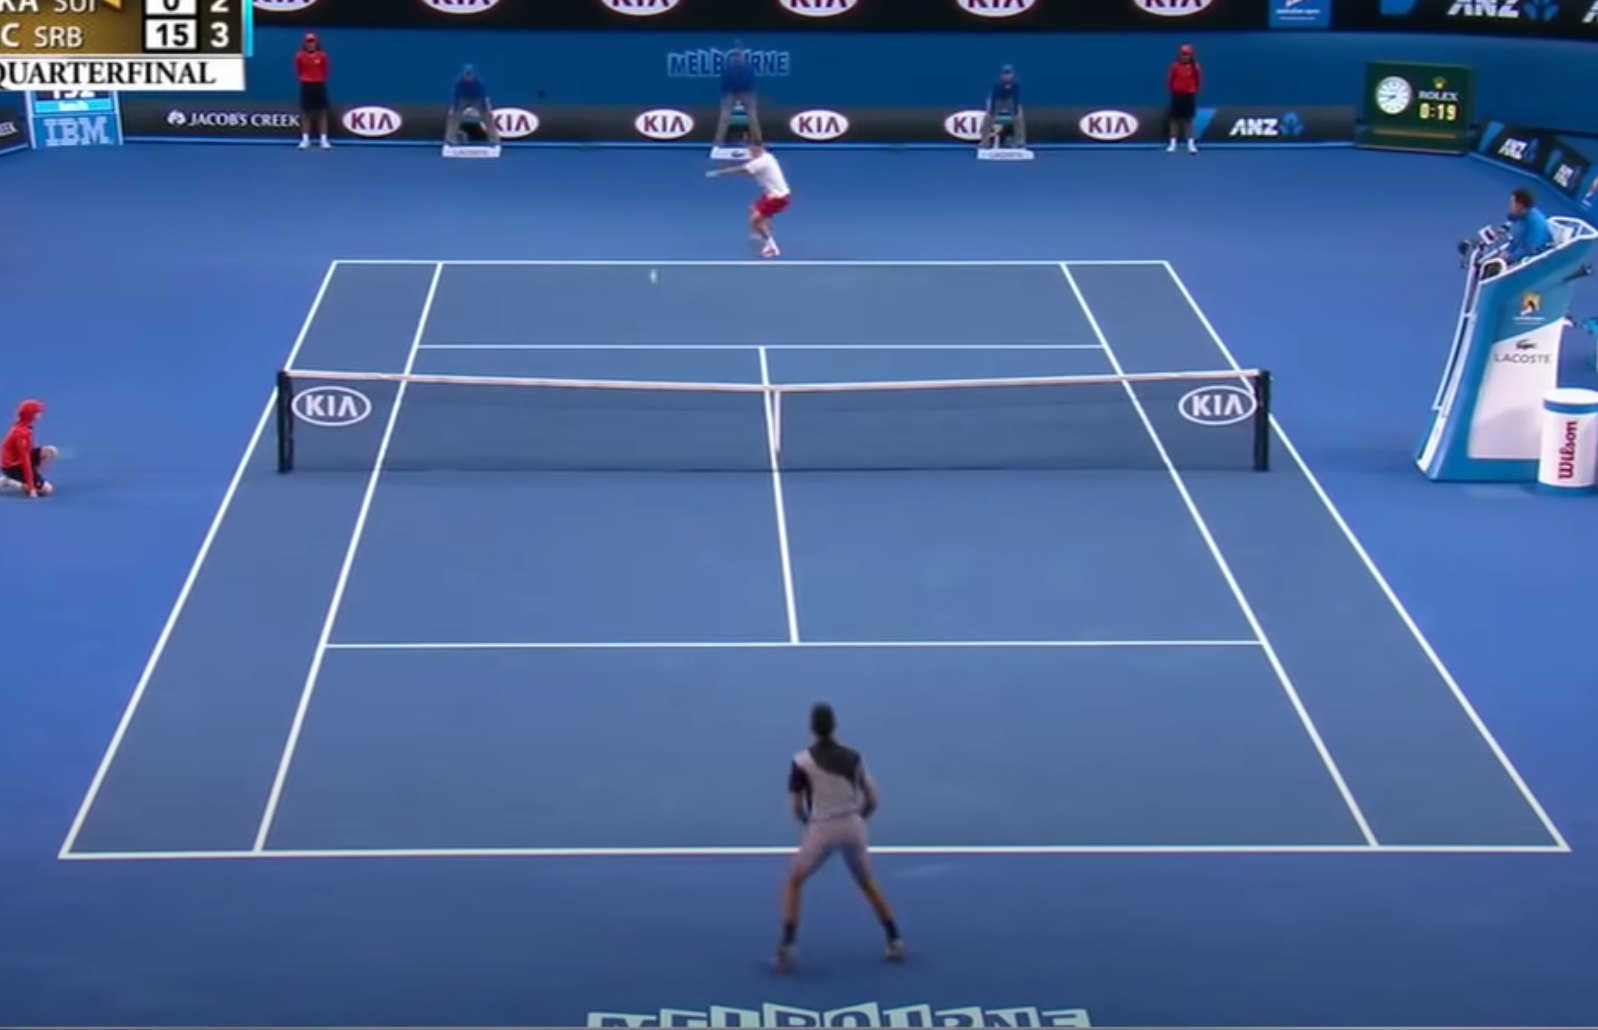

<font color='cyan'>$\textbf{IDEAS FOR SOLVING THE PROBLEM}$</font>

<font color='cyan'>Preprocessing</font>

We may think of creating extra features that might help, for instance, compute the distance between the position of a player and the position of the ball he needs to reach. If the distance is large, meaning that the ball is far from him, it is likely that he won't be able to handle the next shot (ie $y=(-100,-100)$).

We could also add the number of previous shots, because a player is for instance more likely to try a drop shot after a long rally that right at the beginning of a point, even though he may be in the same situation.

<font color='cyan'>Machine Learning</font>

Since we have to deal with sequences as inputs, it is natural to think about <font color='red'>RNN</font>/<font color='red'>LSTM</font>...


